### Distributed Online Riemannian Optimization on Hadamard Manifolds

This Jupyter notebook implements decentralized projected Riemannian gradient descent (DPRGD) in several nonstationary decentralized Riemannian optimization problems. Our experiments include two types of Hadamard manifolds, hyperbolic spaces and the space of symmetric positive definite matrices. For each experiment, we implement both DPRGD and the improved DPRGD and measure the dynamic regret and computational time.

### Hyperbolic Spaces $\mathbb{H}^2$

In [10]:
import numpy as np

import matplotlib.pyplot as plt 

import hyperboloid

import time

In the following experiment, we consider a network of $n=40$ agents, each agent is connected to its nearest 4 neighbors. The weight matrix W is constructed from the Metropolis constant edge weight matrix. In other words, $w_{ij} = 1/5$ if $i=j$ or $i$ and $j$ are connected, otherwise $w_{ij}=0$.

In [11]:
n = 40 # number of agents

K = 100 # number of samples at each node

dim = 2 # dimension of the hyperbolic space

#### 1 - Static setting

We generate $z_i$ from the Riemannian Gaussian distribution with base $\alpha=(1,0,0)$ in the hyperboloid model and $\sigma=5$. Then we draw $\{z_{ik}\}_{k=1}^K$ from the Riemannian Gaussian distribution with base $z_{i}$ and $\sigma=1$.

In [12]:
base = np.array([1, 0, 0])

base_agent = hyperboloid.random_riemannian_gaussian(base, n_samples = n, sigma = 5)

data = np.zeros((n, K, dim + 1))

for i in range(n):

    data[i] = hyperboloid.random_riemannian_gaussian(base_agent[i], n_samples = K, sigma = 1)

full_data = data.reshape(n * K, dim + 1)

global_mean = hyperboloid.frechet_mean(full_data) # global minimizer

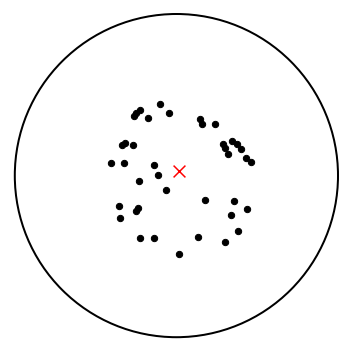

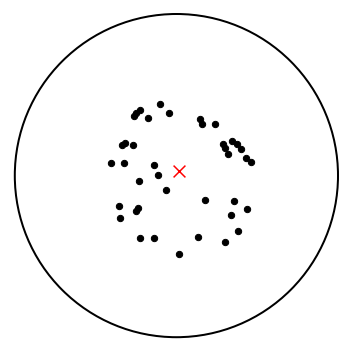

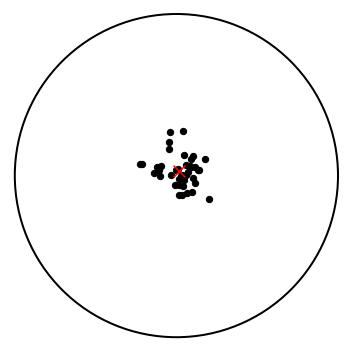

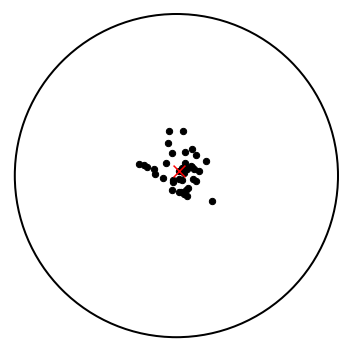

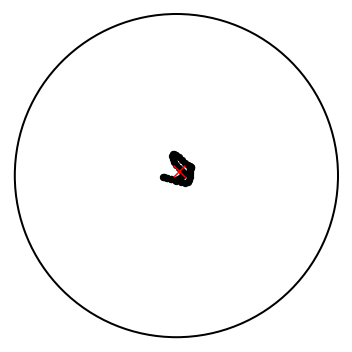

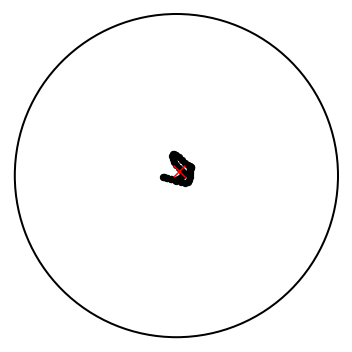

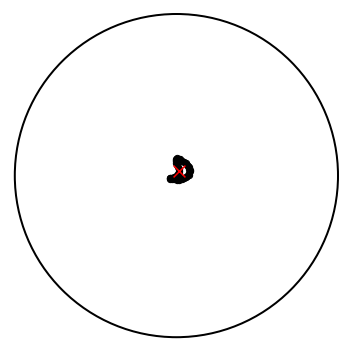

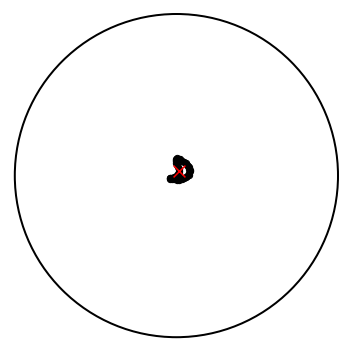

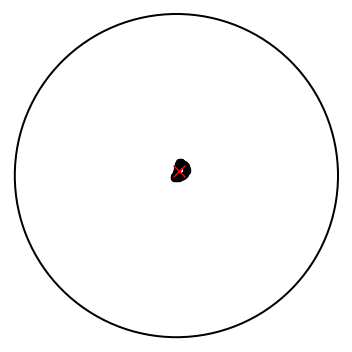

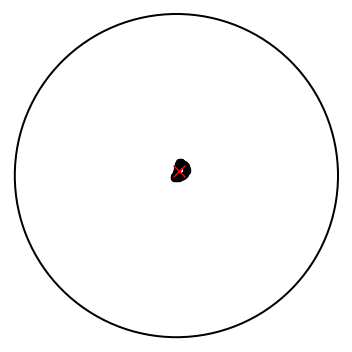

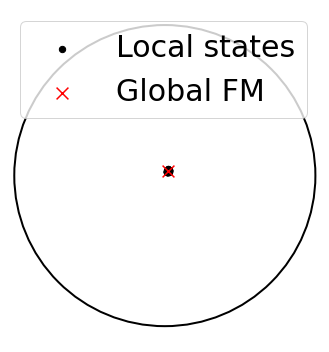

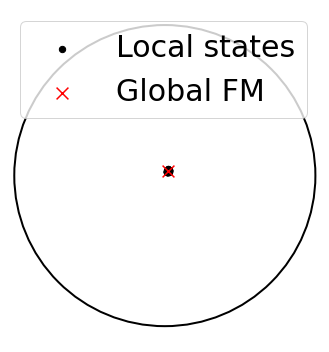

In [15]:
state = np.zeros((n, dim + 1))

state_iDPRGD = np.zeros((n, dim + 1))

for i in range(n):

    state[i] = hyperboloid.frechet_mean(data[i]) # initial state using local frechet means

    state_iDPRGD[i] = state[i]

# t = 1

hyperboloid.visualize(state)

global_mean_poincare = hyperboloid.hyperboloid_to_poincare_ball(global_mean)

plt.scatter(global_mean_poincare[0], global_mean_poincare[1], color = 'red', marker = 'x', s = 140, label = 'Global FM')

#plt.legend(loc = 'upper left', fontsize = 20)

plt.tight_layout()

plt.savefig('figure/hyperbolic_mean_t_0.pdf')

plt.show()

# t = 1, iDPRGD

hyperboloid.visualize(state_iDPRGD)

plt.scatter(global_mean_poincare[0], global_mean_poincare[1], color = 'red', marker = 'x', s = 140, label = 'Global FM')

#plt.legend(loc = 'upper left', fontsize = 20)

plt.tight_layout()

plt.savefig('figure/hyperbolic_mean_t_0_iDPRGD.pdf')

plt.show()

T = 100

stepsize = 0.001

gamma = 1

for t in range(T):

    state_new = np.zeros((n, dim + 1))

    state_iDPRGD_new = np.zeros((n, dim + 1))

    for i in range(n):

        start = (i - 2) % n

        end = (i + 2) % n

        if start < end:

            neighbors_index = list(range(start, end + 1))

        else:

            neighbors_index = list(range(start, n)) + list(range(end + 1))

        state_new[i] = hyperboloid.frechet_mean(state[neighbors_index])

        vector = np.mean(hyperboloid.log(state_iDPRGD[i], state[neighbors_index]), axis = 0)

        state_iDPRGD_new[i] = hyperboloid.exp(state_iDPRGD[i], gamma * vector)

    for i in range(n):

        minus_gradient = np.mean(hyperboloid.log(state_new[i], data[i]), axis = 0)

        state[i] = hyperboloid.exp(state_new[i], stepsize * minus_gradient)

        minus_gradient_iDPRGD = np.mean(hyperboloid.log(state_iDPRGD_new[i], data[i]), axis = 0)

        state_iDPRGD[i] = hyperboloid.exp(state_iDPRGD_new[i], stepsize * minus_gradient_iDPRGD)

    if t == 0 or t == 4 or t == 9 or t == 19 or t == 99:

        hyperboloid.visualize(state)

        plt.scatter(global_mean_poincare[0], global_mean_poincare[1], color = 'red', marker = 'x', s = 140, label = 'Global FM')

        #plt.legend(loc = 'upper left', fontsize = 20)

        if t == 99:

            plt.legend(loc = 'upper right', fontsize = 30)

        plt.tight_layout()

        plt.savefig('figure/hyperbolic_mean_t_' + str(t+1) + '.pdf')

        plt.show()

        hyperboloid.visualize(state_iDPRGD)

        plt.scatter(global_mean_poincare[0], global_mean_poincare[1], color = 'red', marker = 'x', s = 140, label = 'Global FM')

        #plt.legend(loc = 'upper left', fontsize = 20)
        
        if t == 99:

            plt.legend(loc = 'upper right', fontsize = 30)

        plt.tight_layout()

        plt.savefig('figure/hyperbolic_mean_t_' + str(t+1) + '_iDPRGD.pdf')


#### 2 - Abrupt changing

We consider $T=400$ and let $\{f_{i,t}\}$ change every $T_0$ epochs, where $T_0\in\{25,40,80\}$ are examined. 
- When $t/T_0$ is an odd integer, we draw $\{z_i^t\}$ from the Riemannian Gaussian distribution with $\alpha=(3,2,2)$ and $\sigma=5$. Then we generate $\{z_{ik}^t\}$ from the Riemannian Gaussian distribution with $\alpha=z_i^t$ and $\sigma=1$. These $\{z_{ik}^t\}$ remain the same until $t/T_0$ reaches next integer. 
- When $t/T_0$ is an even integer, we draw $\{z_i^t\}$ from the Riemannian Gaussian distribution with $\alpha=(1,0,0)$ and $\sigma=5$. Then we generate $\{z_{ik}^t\}$ from the Riemannian Gaussian distribution with $\alpha=z_i^t$ and $\sigma=1$. These $\{z_{ik}^t\}$ remain unchanged until $t/T_0$ reaches next integer.

In [17]:
# data T rounds n agents K samples 2(3) dimension

n = 40 # number of agents

K = 100 # number of samples at each node

dim = 2 # dimension of the hyperbolic space

T = 400

T0_candidate = np.array([25, 40, 80])

stepsize = 0.05

gamma = 1

# regret and runtime for DPRGD and iDPRGD, results

dynamic_regret = np.zeros((len(T0_candidate), T))

runtime = np.zeros((len(T0_candidate), T))

dynamic_regret_iDPRGD = np.zeros((len(T0_candidate), T))

runtime_iDPRGD = np.zeros((len(T0_candidate), T))

# data generation

data = np.zeros((len(T0_candidate), T, n, K, dim + 1))

loss_global = np.zeros((len(T0_candidate), T))

In [24]:
# 3 mins

# data generation

for s in range(len(T0_candidate)):

    T0 = T0_candidate[s]

    for t in range(T):

        if t % T0 == 0: # generate new data

            if (t // T0) % 2 == 0:

                base = np.array([1, 0, 0])

            else:

                base = np.array([3, 2, 2])

            base_agent = hyperboloid.random_riemannian_gaussian(base, n_samples = n, sigma = 5)

            for i in range(n):

                data[s, t, i, ...] = hyperboloid.random_riemannian_gaussian(base_agent[i], n_samples = K, sigma = 1)
            
            full_data = data[s, t, ...].reshape(n * K, dim + 1)

            global_mean = hyperboloid.frechet_mean(full_data)

            loss_global[s, t] = np.mean(hyperboloid.dist(global_mean, full_data) ** 2)

        else: # data remains the same

            data[s, t, ...] = data[s, t - 1, ...]

            loss_global[s, t] = loss_global[s, t - 1]  

In [25]:
# 3 mins 20 s

# DPRGD

state = np.zeros((n, dim + 1))

for s in range(len(T0_candidate)):

    start_time = time.time()

    for t in range(T):

        # initialization only at time t = 0

        if t == 0:

            for i in range(n):

                state[i] = hyperboloid.frechet_mean(data[s, t, i, ...]) # initial state using local frechet means

        # evaluate the local loss

        loss_local = np.zeros(n)

        full_data = data[s, t, ...].reshape(n * K, dim + 1)

        for i in range(n):

            loss_local[i] = np.mean(hyperboloid.dist(state[i], full_data) ** 2)
        
        if t == 0:

            dynamic_regret[s, t] = np.mean(loss_local) - loss_global[s, t]

        else:

            dynamic_regret[s, t] = dynamic_regret[s, t - 1] + np.mean(loss_local) - loss_global[s, t]

        end_time = time.time()

        runtime[s, t] = end_time - start_time

        state_new = np.zeros((n, dim + 1))

        # consensus step using weighted Frechet mean

        for i in range(n):

            start = (i - 2) % n

            end = (i + 2) % n

            if start < end:

                neighbors_index = list(range(start, end + 1))

            else:

                neighbors_index = list(range(start, n)) + list(range(end + 1))

            state_new[i] = hyperboloid.frechet_mean(state[neighbors_index])

        # gradient step

        for i in range(n):

            minus_gradient = np.mean(hyperboloid.log(state_new[i], data[s, t, i, ...]), axis = 0)

            state[i] = hyperboloid.exp(state_new[i], stepsize * minus_gradient)

In [27]:
# 20 s

# iDPRGD

state_iDPRGD = np.zeros((n, dim + 1))

for s in range(len(T0_candidate)):

    start_time = time.time()

    for t in range(T):

        # initialization only at time t = 0

        if t == 0:

            for i in range(n):

                state_iDPRGD[i] = hyperboloid.frechet_mean(data[s, t, i, ...]) # initial state_iDPRGD using local frechet means

        # evaluate the local loss

        loss_local = np.zeros(n)

        full_data = data[s, t, ...].reshape(n * K, dim + 1)

        for i in range(n):

            loss_local[i] = np.mean(hyperboloid.dist(state_iDPRGD[i], full_data) ** 2)
        
        if t == 0:

            dynamic_regret_iDPRGD[s, t] = np.mean(loss_local) - loss_global[s, t]

        else:

            dynamic_regret_iDPRGD[s, t] = dynamic_regret_iDPRGD[s, t - 1] + np.mean(loss_local) - loss_global[s, t]

        end_time = time.time()

        runtime_iDPRGD[s, t] = end_time - start_time

        state_iDPRGD_new = np.zeros((n, dim + 1))

        # consensus step using single-step Riemannian gradient descent

        for i in range(n):

            start = (i - 2) % n

            end = (i + 2) % n

            if start < end:

                neighbors_index = list(range(start, end + 1))

            else:

                neighbors_index = list(range(start, n)) + list(range(end + 1))

            vector = np.mean(hyperboloid.log(state_iDPRGD[i], state_iDPRGD[neighbors_index]), axis = 0)

            state_iDPRGD_new[i] = hyperboloid.exp(state_iDPRGD[i], gamma * vector)

        # gradient step

        for i in range(n):

            minus_gradient = np.mean(hyperboloid.log(state_iDPRGD_new[i], data[s, t, i, ...]), axis = 0)

            state_iDPRGD[i] = hyperboloid.exp(state_iDPRGD_new[i], stepsize * minus_gradient)

Visualize the dynamic regret

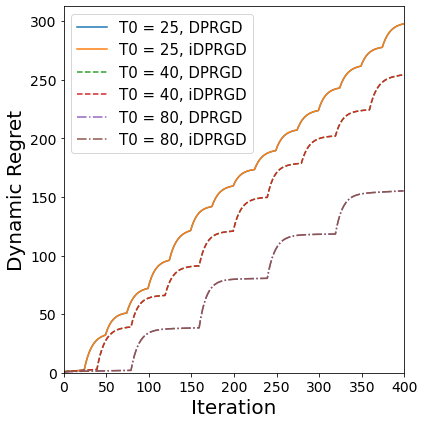

In [31]:
fig = plt.figure(figsize = (6, 6))

linestyle_candidate = ['-', '--', '-.']

for s in range(len(T0_candidate)):

    plt.plot(np.arange(T), dynamic_regret[s], label = 'T0 = ' + str(T0_candidate[s]) + ', DPRGD', linestyle = linestyle_candidate[s])
    
    plt.plot(np.arange(T), dynamic_regret_iDPRGD[s], label = 'T0 = ' + str(T0_candidate[s]) + ', iDPRGD', linestyle = linestyle_candidate[s])

plt.legend(fontsize = 15)

plt.xlabel('Iteration', fontsize = 20)

plt.ylabel('Dynamic Regret', fontsize = 20) 

plt.xlim(0, T)

plt.ylim(0, None)

plt.xticks(fontsize=14)

plt.yticks(fontsize=14)

plt.tight_layout()

plt.savefig('figure/hyperbolic_mean_dynamic_regret_A.pdf')

plt.show()



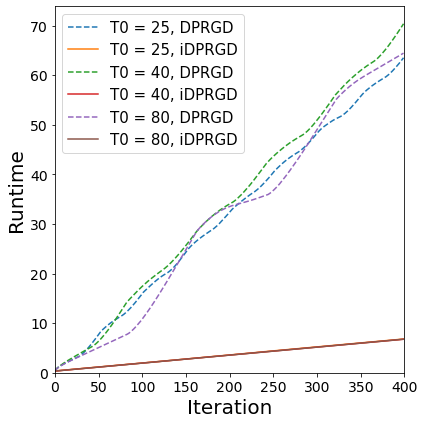

In [35]:
fig = plt.figure(figsize = (6, 6))

linestyle_candidate = ['-', '--', '-.']

for s in range(len(T0_candidate)):

    plt.plot(np.arange(T), runtime[s], label = 'T0 = ' + str(T0_candidate[s]) + ', DPRGD', linestyle = '--')

    plt.plot(np.arange(T), runtime_iDPRGD[s], label = 'T0 = ' + str(T0_candidate[s]) + ', iDPRGD', linestyle = '-')

plt.legend(fontsize = 15)

plt.xlabel('Iteration', fontsize = 20)

plt.ylabel('Runtime', fontsize = 20) 

plt.xlim(0, T)

plt.ylim(0, None)

plt.xticks(fontsize=14)

plt.yticks(fontsize=14)

plt.tight_layout()

plt.savefig('figure/hyperbolic_mean_runtime_A.pdf')

plt.show()



#### 3 - General changing

We consider $T=400$ and allow $\{f_{i,t}\}$ to change abruptly and gradually. Specifically, we set a period length $T_0\in\{25,40,80\}$ and express each $t=sT+r$ with nonnegative integers $s$ and $r$. At time $t$, we set base as $\sinh(r/T_0)(1,0,0)+\sinh(r/T0)(0,1/\sqrt{2},1/\sqrt{2})$. Then we draw samples $\{z_i^t\}$ from the Riemannian Gaussian distribution with this base and $\sigma=5$. Next, we draw $\{z_{ik}\}$ from the Riemannian radial distribution with $\alpha=z_i^t$ and $\sigma=1$.

In [36]:
# data T rounds n agents K samples 2(3) dimension

n = 40 # number of agents

K = 100 # number of samples at each node

dim = 2 # dimension of the hyperbolic space

T = 400

T0_candidate = np.array([25, 40, 80])

stepsize = 0.05

gamma = 1

# results

dynamic_regret = np.zeros((len(T0_candidate), T))

runtime = np.zeros((len(T0_candidate), T))

dynamic_regret_iDPRGD = np.zeros((len(T0_candidate), T))

runtime_iDPRGD = np.zeros((len(T0_candidate), T))

# data generation

data = np.zeros((len(T0_candidate), T, n, K, dim + 1))

loss_global = np.zeros((len(T0_candidate), T))

In [37]:
# 110 mins

# data generation

for s in range(len(T0_candidate)):

    T0 = T0_candidate[s]

    for t in range(T):

        r = t % T0

        base = np.array([1, 0, 0]) * np.cosh(r / T0) + np.array([0, 1 / np.sqrt(2), 1 / np.sqrt(2)]) * np.sinh(r / T0)

        base_agent = hyperboloid.random_riemannian_gaussian(base, n_samples = n, sigma = 5)

        for i in range(n):

            data[s, t, i, ...] = hyperboloid.random_riemannian_gaussian(base_agent[i], n_samples = K, sigma = 1)

        full_data = data[s, t, ...].reshape(n * K, dim + 1)

        global_mean = hyperboloid.frechet_mean(full_data)

        loss_global[s, t] = np.mean(hyperboloid.dist(global_mean, full_data) ** 2)

In [38]:
# 3 mins

# DPRGD

state = np.zeros((n, dim + 1))

for s in range(len(T0_candidate)):

    T0 = T0_candidate[s]

    start_time = time.time()

    for t in range(T):
        
        # initialization only at time t = 0

        if t == 0:

            for i in range(n):

                state[i] = hyperboloid.frechet_mean(data[s, t, i, ...]) # initial state using local frechet means

        # evaluate the local loss

        loss_local = np.zeros(n)

        full_data = data[s, t, ...].reshape(n * K, dim + 1)

        for i in range(n):

            loss_local[i] = np.mean(hyperboloid.dist(state[i], full_data) ** 2)

        if t == 0:

            dynamic_regret[s, t] = np.mean(loss_local) - loss_global[s, t]

        else:

            dynamic_regret[s, t] = dynamic_regret[s, t - 1] + np.mean(loss_local) - loss_global[s, t]

        end_time = time.time()

        runtime[s, t] = end_time - start_time

        # update state

        state_new = np.zeros((n, dim + 1))

        # consensus step using weighted Frechet mean

        for i in range(n):

            start = (i - 2) % n

            end = (i + 2) % n

            if start < end:

                neighbors_index = list(range(start, end + 1))

            else:

                neighbors_index = list(range(start, n)) + list(range(end + 1))

            state_new[i] = hyperboloid.frechet_mean(state[neighbors_index])

        # gradient step

        for i in range(n):

            minus_gradient = np.mean(hyperboloid.log(state_new[i], data[s, t, i, ...]), axis = 0)

            state[i] = hyperboloid.exp(state_new[i], stepsize * minus_gradient)

In [39]:
# 20 s

# iDPRGD

state_iDPRGD = np.zeros((n, dim + 1))

for s in range(len(T0_candidate)):

    start_time = time.time()

    T0 = T0_candidate[s]

    for t in range(T):
        
        # initialization only at time t = 0

        if t == 0:

            for i in range(n):

                state_iDPRGD[i] = hyperboloid.frechet_mean(data[s, t, i, ...]) # initial state_iDPRGD using local frechet means

        # evaluate the local loss

        loss_local = np.zeros(n)

        full_data = data[s, t, ...].reshape(n * K, dim + 1)

        for i in range(n):

            loss_local[i] = np.mean(hyperboloid.dist(state_iDPRGD[i], full_data) ** 2)

        if t == 0:

            dynamic_regret_iDPRGD[s, t] = np.mean(loss_local) - loss_global[s, t]

        else:

            dynamic_regret_iDPRGD[s, t] = dynamic_regret_iDPRGD[s, t - 1] + np.mean(loss_local) - loss_global[s, t]

        end_time = time.time()

        runtime_iDPRGD[s, t] = end_time - start_time

        # update state_iDPRGD

        state_iDPRGD_new = np.zeros((n, dim + 1))

        # consensus step using single-step Riemannian gradient descent

        for i in range(n):

            start = (i - 2) % n

            end = (i + 2) % n

            if start < end:

                neighbors_index = list(range(start, end + 1))

            else:

                neighbors_index = list(range(start, n)) + list(range(end + 1))

            vector = np.mean(hyperboloid.log(state_iDPRGD[i], state_iDPRGD[neighbors_index]), axis = 0)

            state_iDPRGD_new[i] = hyperboloid.exp(state_iDPRGD[i], gamma * vector)

        # gradient step

        for i in range(n):

            minus_gradient = np.mean(hyperboloid.log(state_iDPRGD_new[i], data[s, t, i, ...]), axis = 0)

            state_iDPRGD[i] = hyperboloid.exp(state_iDPRGD_new[i], stepsize * minus_gradient)

Visualize the dynamic regret

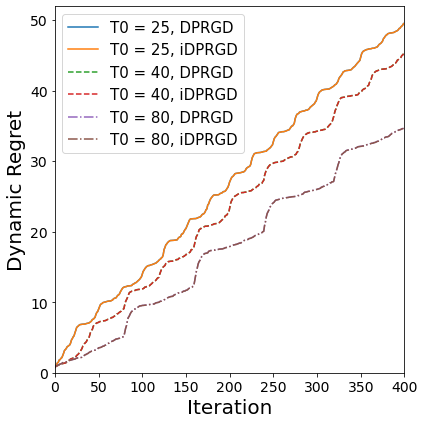

In [40]:
fig = plt.figure(figsize = (6, 6))

linestyle_candidate = ['-', '--', '-.']

for s in range(len(T0_candidate)):

    plt.plot(np.arange(T), dynamic_regret[s], label = 'T0 = ' + str(T0_candidate[s]) + ', DPRGD', linestyle = linestyle_candidate[s])

    plt.plot(np.arange(T), dynamic_regret_iDPRGD[s], label = 'T0 = ' + str(T0_candidate[s]) + ', iDPRGD', linestyle = linestyle_candidate[s])

plt.legend(fontsize = 15)

plt.xlabel('Iteration', fontsize = 20)

plt.ylabel('Dynamic Regret', fontsize = 20) 

plt.xlim(0, T)

plt.ylim(0, None)

plt.xticks(fontsize=14)

plt.yticks(fontsize=14)

plt.tight_layout()

plt.savefig('figure/hyperbolic_mean_dynamic_regret_C.pdf')

plt.show()

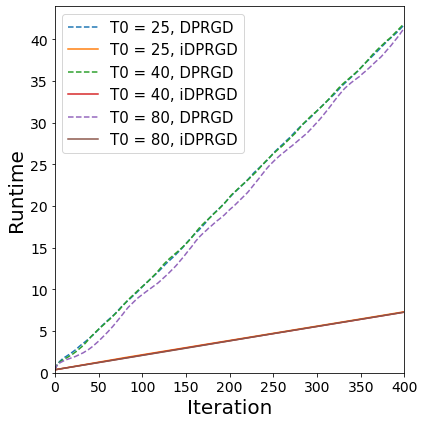

In [41]:
fig = plt.figure(figsize = (6, 6))

for s in range(len(T0_candidate)):

    plt.plot(np.arange(T), runtime[s], label = 'T0 = ' + str(T0_candidate[s]) + ', DPRGD', linestyle = '--')

    plt.plot(np.arange(T), runtime_iDPRGD[s], label = 'T0 = ' + str(T0_candidate[s]) + ', iDPRGD', linestyle = '-')

plt.legend(fontsize = 15)

plt.xlabel('Iteration', fontsize = 20)

plt.ylabel('Runtime', fontsize = 20) 

plt.xlim(0, T)

plt.ylim(0, None)

plt.xticks(fontsize=14)

plt.yticks(fontsize=14)

plt.tight_layout()

plt.savefig('figure/hyperbolic_mean_runtime_C.pdf')

plt.show()

### Symmetric Positive Definite Matrices

In [1]:
import numpy as np

import matplotlib.pyplot as plt 

import spd

import time

In the following experiment, we consider a network of $n=8$ agents, each agent is connected to its nearest 4 neighbors. The weight matrix W is constructed from the Metropolis constant edge weight matrix. In other words, $w_{ij} = 1/5$ if $i=j$ or $i$ and $j$ are connected, otherwise $w_{ij}=0$.

In [2]:
n = 10 # number of agents

K = 20 # number of samples at each node

dim = 3 # consider 3 by 3 symmetric positive definite matrices

T = 80

T0_candidate = np.array([5, 10, 20])

stepsize = 0.1

gamma = 1

# regret and runtime for DPRGD and iDPRGD, results

dynamic_regret = np.zeros((len(T0_candidate), T))

runtime = np.zeros((len(T0_candidate), T))

dynamic_regret_iDPRGD = np.zeros((len(T0_candidate), T))

runtime_iDPRGD = np.zeros((len(T0_candidate), T))

# data generation

data = np.zeros((len(T0_candidate), T, n, K, dim, dim))

loss_global = np.zeros((len(T0_candidate), T))

Consider $T=80$ and $T_0\in\{5,10,20\}$.

For the first 30 steps, we assume $\{f_{it}\}$ change abruptly. 

- When $t/T_0$ is an odd integer, we draw $Z_i^t\sim{\rm Exp}_I(V)$ where $V$ is a symmetric matrix with ${\cal U}(0,0.1)$ entries. Then we draw $\{Z_{ik}^t\}\sim{\rm Exp}_{Z_i^t}(V)$ where $V$ is a symmetric matrix with ${\cal U}(0,0.1)$ entries. 
- When $t/T_0$ is an even integer, we repeat the above procedure except that we replace $I$ by $3I$.

For the rest steps, we assume $\{f_{it}\}$ change abruptly and gradually. We let $t=sT_0+r$ with nonnegative integers $s$ and $r$. Then at time $t$, we draw $Z_i^t\sim{\rm Exp}_{(1+2 r/T_0)I}(V)$ where symmetric $V$ contains ${\cal U}(0,0.1)$ entries. Then we draw $\{Z_{ik}^t\}\sim{\rm Exp}_{Z_{i}^t}(V)$ where $V$ is a symmetric matrix with ${\cal U}(0,0.1)$ entries. 

In [3]:
# 63 mins

# data generation

for s in range(len(T0_candidate)):

    T0 = T0_candidate[s]

    for t in range(T):

        if t < 40:

            if t % T0 == 0: # generate new data

                if (t // T0) % 2 == 0:

                    base = np.eye(dim)
                
                else:

                    base = 3 * np.eye(dim)
                
                base_agent = spd.random(base, n_samples = n, radius = 0.1)

                for i in range(n):

                    data[s, t, i, ...] = spd.random(base_agent[i], n_samples = K, radius = 0.1)

                full_data = data[s, t, ...].reshape(n * K, dim, dim)

                global_mean = spd.frechet_mean(full_data)

                loss_global[s, t] = np.mean(spd.dist(global_mean, full_data) ** 2)
            
            else:

                data[s, t, ...] = data[s, t - 1, ...]

                loss_global[s, t] = loss_global[s, t - 1]

        else:

            r = t % T0

            base = np.eye(dim) * (1 + r / T0 * 2)

            base_agent = spd.random(base, n_samples = n, radius = 0.1)

            for i in range(n):

                data[s, t, i, ...] = spd.random(base_agent[i], n_samples = K, radius = 0.1)

            full_data = data[s, t, ...].reshape(n * K, dim, dim)

            global_mean = spd.frechet_mean(full_data)

            loss_global[s, t] = np.mean(spd.dist(global_mean, full_data) ** 2)

In [4]:
# 27 mins

# DPRGD

state = np.zeros((n, dim, dim))

for s in range(len(T0_candidate)):

    T0 = T0_candidate[s]

    start_time = time.time()

    for t in range(T):

        # initialization only at time t = 0 

        if t == 0:

            for i in range(n):

                state[i] = data[s, t, i][0] # initial state using the first sample

        # evaluate the local loss

        loss_local = np.zeros(n)

        full_data = data[s, t, ...].reshape(n * K, dim, dim)

        for i in range(n):

            loss_local[i] = np.mean(spd.dist(state[i], full_data) ** 2)

        if t == 0:

            dynamic_regret[s, t] = np.mean(loss_local) - loss_global[s, t]

        else:

            dynamic_regret[s, t] = dynamic_regret[s, t - 1] + np.mean(loss_local) - loss_global[s, t]

        end_time = time.time()

        runtime[s, t] = end_time - start_time

        # update state

        state_new = np.zeros((n, dim, dim))

        # consensus step using weighted Frechet mean

        for i in range(n):

            start = (i - 2) % n

            end = (i + 2) % n

            if start < end:

                neighbors_index = list(range(start, end + 1))

            else:

                neighbors_index = list(range(start, n)) + list(range(end + 1))

            state_new[i] = spd.frechet_mean(state[neighbors_index])

        # gradient step

        for i in range(n):

            minus_gradient = np.mean(spd.log(state_new[i], data[s, t, i, ...]), axis = 0)

            state[i] = spd.exp(state_new[i], stepsize * minus_gradient)

In [5]:
# 19 mins

# iDPRGD

state_iDPRGD = np.zeros((n, dim, dim))

for s in range(len(T0_candidate)):

    T0 = T0_candidate[s]

    start_time = time.time()

    for t in range(T):

        # initialization only at time t = 0 

        if t == 0:

            for i in range(n):

                state_iDPRGD[i] = data[s, t, i][0] # initial state_iDPRGD using the first sample

        # evaluate the local loss

        loss_local = np.zeros(n)

        full_data = data[s, t, ...].reshape(n * K, dim, dim)

        for i in range(n):

            loss_local[i] = np.mean(spd.dist(state_iDPRGD[i], full_data) ** 2)

        if t == 0:

            dynamic_regret_iDPRGD[s, t] = np.mean(loss_local) - loss_global[s, t]

        else:

            dynamic_regret_iDPRGD[s, t] = dynamic_regret_iDPRGD[s, t - 1] + np.mean(loss_local) - loss_global[s, t]

        end_time = time.time()

        runtime_iDPRGD[s, t] = end_time - start_time

        # update state_iDPRGD

        state_iDPRGD_new = np.zeros((n, dim, dim))

        # consensus step using weighted Frechet mean

        for i in range(n):

            start = (i - 2) % n

            end = (i + 2) % n

            if start < end:

                neighbors_index = list(range(start, end + 1))

            else:

                neighbors_index = list(range(start, n)) + list(range(end + 1))

            vector = np.mean(spd.log(state_iDPRGD[i], state_iDPRGD[neighbors_index]), axis = 0)

            state_iDPRGD_new[i] = spd.exp(state_iDPRGD[i], gamma * vector)

        # gradient step

        for i in range(n):

            minus_gradient = np.mean(spd.log(state_iDPRGD_new[i], data[s, t, i, ...]), axis = 0)

            state_iDPRGD[i] = spd.exp(state_iDPRGD_new[i], stepsize * minus_gradient)

Visualize the dynamic regret

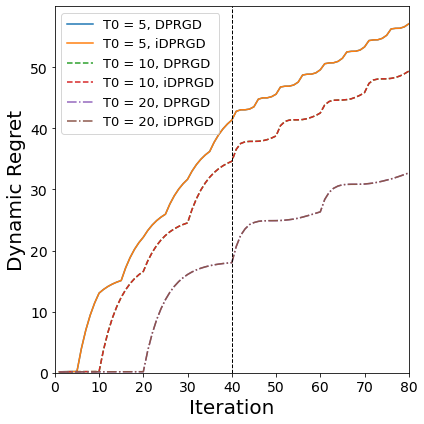

In [13]:
fig, axs = plt.subplots(1, 1, figsize = (6, 6))

ax = axs 

linestyle_candidate = ['-', '--', '-.']

for s in range(len(T0_candidate)):

    ax.plot(np.arange(1, T+1), dynamic_regret[s], label = 'T0 = ' + str(T0_candidate[s]) + ', DPRGD', linestyle = linestyle_candidate[s])

    ax.plot(np.arange(1, T+1), dynamic_regret_iDPRGD[s], label = 'T0 = ' + str(T0_candidate[s]) + ', iDPRGD', linestyle = linestyle_candidate[s])

ax.legend(fontsize = 13)

ax.set_xlabel('Iteration', fontsize = 20)

ax.set_ylabel('Dynamic Regret', fontsize = 20)  

ax.set_ylim(0, None) 

ax.set_xlim(0, 80)

ax.tick_params(axis = 'both', labelsize = 14) 

ax.axvline(x = 40, color='black', linestyle='--', alpha = 1, lw = 1)

plt.tight_layout()

plt.savefig('figure/SPD_dynamic_regret.pdf')

plt.show()

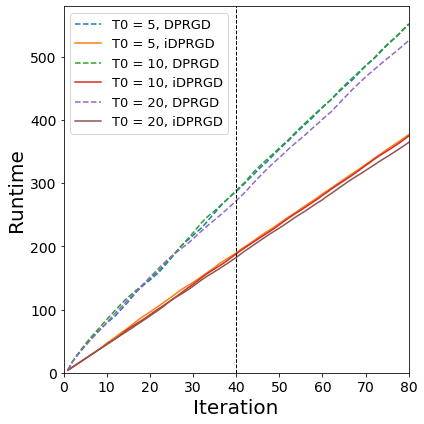

In [14]:
fig, axs = plt.subplots(1, 1, figsize = (6, 6))

ax = axs 

linestyle_candidate = ['-', '--', '-.']

for s in range(len(T0_candidate)):

    ax.plot(np.arange(1, T+1), runtime[s], label = 'T0 = ' + str(T0_candidate[s]) + ', DPRGD', linestyle = '--')

    ax.plot(np.arange(1, T+1), runtime_iDPRGD[s], label = 'T0 = ' + str(T0_candidate[s]) + ', iDPRGD', linestyle = '-')

ax.legend(fontsize = 13)

ax.set_xlabel('Iteration', fontsize = 20)

ax.set_ylabel('Runtime', fontsize = 20)  

ax.set_ylim(0, None) 

ax.set_xlim(0, 80)

ax.tick_params(axis = 'both', labelsize = 14) 

ax.axvline(x = 40, color='black', linestyle='--', alpha = 1, lw = 1)

plt.tight_layout()

plt.savefig('figure/SPD_runtime.pdf')

plt.show()